In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from Backtester.SignalLibrary import Signals
import Portfolio.PortHelper as ph
from Backtester import SignalHelper as sh
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [22]:
us_tickers = ['SPX Index','SPXT Index', 'MLT1US10 Index', 'BCOMTR Index',
              'PUT Index', 'BXMD Index', 'CMBO Index', 'VIX Index', 'UX1 A:03_0_R Index']
us_df = Signals.signal_get_data(us_tickers, 'PX_LAST', '19860101').pull()
us_df.columns = ['SPX Spot', 'SPX', 'US10', 'BCOM', 'PUT','BXM', 'CMBO', 'VIX', 'UX1']
rf_df = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start='19800101')[0]['RF']
us_df['rf'] = rf_df.shift(1)/(100)

sp_ivol = Signals.signal_get_data('SPX Index', 
                                  '30DAY_IMPVOL_100.0%MNY_DF',
                                  '20000101').pull().to_frame('atm_impvol')
sp_ivol['del_impvol'] = sp_ivol['atm_impvol'].diff()
sp_ivol['del_impvol_2'] = sp_ivol['atm_impvol'].diff()**2

us_df['del_VIX'] = us_df['VIX'].diff()
us_df['del_VIX_2'] = us_df['del_VIX']**2
us_df[['r_SPX', 'r_US10','r_BCOM','r_PUT', 'r_BXM', 'r_CMBO']] = \
            us_df[['SPX','US10','BCOM','PUT','BXM','CMBO']].pct_change()

vrp_df = pd.read_pickle('VRP.pkl')
vrp_df['SPXDHSTR'] = Signals.signal_get_data('SPXDHSTR Index', 
                                             'PX_LAST','20000101').pull().pct_change()
us_df[['r_Short_Straddle','r_Short_Strangle','r_VRP_SPX_Combo']] = vrp_df.copy()
us_df['r_sVIX'] = Signals.signal_get_data('UX1 A:03_0_R Index', 'PX_LAST', '19860101').pull().\
                    pct_change().add(us_df['rf']/252)*-1
# us_df['r_VOL'] = us_df[['r_CMBO']]

In [24]:
def get_port_stats(rets):
    
    global us_df
    mu_arth = rets.subtract(us_df['rf'],axis=0).mean()*252
    cum_rets = (1+rets).cumprod().dropna()
    mu_geo = cum_rets.iloc[-1]**(252/len(rets))-1
    max_dd = (cum_rets.divide(cum_rets.cummax())-1).abs().max()
    vol = rets.subtract(us_df['rf'],axis=0).std()*np.sqrt(252)
    sharpe = mu_arth/vol
    
    return pd.Series([mu_geo, vol, max_dd, sharpe], 
                     index=['Compound Return', 
                            'Volatility', 
                            'Max DD', 
                            'Sharpe Ratio'])

us_df[['r_SPX','r_US10','r_BCOM','r_PUT']].apply(get_port_stats)

,r_SPX,r_US10,r_BCOM,r_PUT
Compound Return,0.101993,0.068730,0.036681,0.092210
Volatility,0.179760,0.061402,0.144354,0.131358
Max DD,0.552502,0.124298,0.732484,0.370940
Sharpe Ratio,0.525513,0.674765,0.120396,0.544939


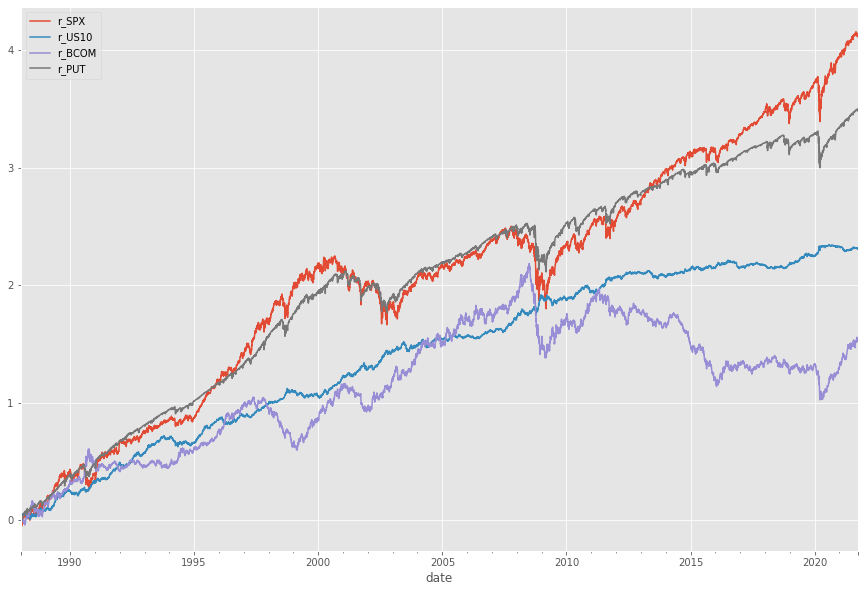

In [25]:
us_df[['r_SPX','r_US10','r_BCOM','r_PUT']].dropna().cumsum().plot()

In [26]:
us_df[['r_SPX','r_US10','r_BCOM','r_PUT']].corr()

,r_SPX,r_US10,r_BCOM,r_PUT
r_SPX,1.000000,-0.144320,0.186478,0.884969
r_US10,-0.144320,1.000000,-0.149701,-0.115568
r_BCOM,0.186478,-0.149701,1.000000,0.147442
r_PUT,0.884969,-0.115568,0.147442,1.000000


In [27]:
us_df['SBC_ew'] = us_df[['r_SPX','r_US10','r_BCOM']].dropna().mean(axis=1)
us_df['SBCV_ew'] = us_df[['r_SPX','r_US10','r_BCOM','r_PUT']].dropna().mean(axis=1)
us_df['60/40'] = us_df[['r_SPX','r_US10']].dropna().dot(np.array([0.6, 0.4]))

us_df[['SBC_ew','SBCV_ew','60/40']].apply(get_port_stats)

,SBC_ew,SBCV_ew,60/40
Compound Return,0.071376,0.077155,0.090706
Volatility,0.082332,0.085722,0.106999
Max DD,0.338725,0.343729,0.307989
Sharpe Ratio,0.616892,0.663249,0.681909


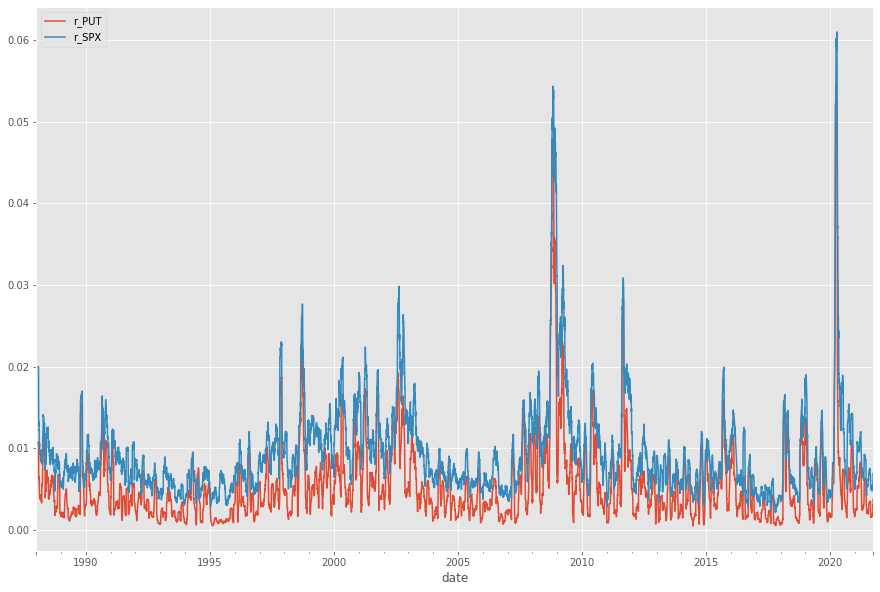

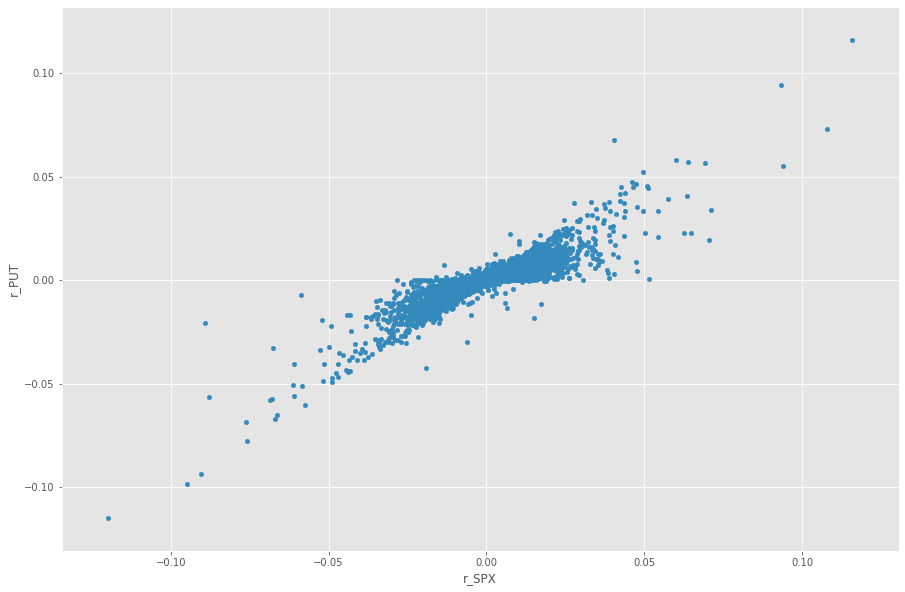

In [28]:
us_df[['r_PUT','r_SPX']].dropna().rolling(21).std().plot()
us_df[['r_PUT','r_SPX']].plot(kind='scatter',x='r_SPX',y='r_PUT')

In [29]:
vol_tgt = 0.15
us_df['corr_spx_put'] = us_df[['r_SPX','r_PUT']].ewm(halflife=int(0.50*252),
                                min_periods=5).corr(us_df['r_PUT'])['r_SPX']
us_df['vol_spx'] = us_df[['r_SPX']].ewm(halflife=int(0.50*252),
                                min_periods=5).std()
us_df['vol_put'] = us_df[['r_PUT']].ewm(halflife=int(0.50*252),
                                min_periods=5).std()
us_df['put_beta'] = us_df['corr_spx_put'].multiply((us_df['vol_put'].divide(us_df['vol_spx'])))
us_df['r_PUT_betaadj'] = us_df['r_PUT'].subtract(us_df['put_beta'].shift(5).multiply(us_df['r_SPX']))
lev_ratio = vol_tgt/(us_df['r_PUT_betaadj'].ewm(halflife=int(0.10*252),min_periods=5).std()*np.sqrt(252))
us_df['r_PUT_betaadj'] = lev_ratio.shift(1).multiply(us_df['r_PUT_betaadj'], axis=0)

us_df[['r_SPX','r_US10','r_BCOM','r_PUT_betaadj']].corr()

,r_SPX,r_US10,r_BCOM,r_PUT_betaadj
r_SPX,1.000000,-0.144320,0.186478,-0.052320
r_US10,-0.144320,1.000000,-0.149701,-0.045229
r_BCOM,0.186478,-0.149701,1.000000,-0.043498
r_PUT_betaadj,-0.052320,-0.045229,-0.043498,1.000000


In [30]:
us_df['rvol_SPX'] = us_df['r_SPX'].rolling(22).std()*(np.sqrt(252)*100)
us_df['PUT_betaadj'] = us_df['r_PUT_betaadj'].apply(lambda x: 1+x).cumprod()

vrp_test = us_df[['VIX','PUT_betaadj']].resample('M').last()
vrp_test['RVOL'] = us_df['r_SPX'].groupby(pd.Grouper(freq='M')).std()*(np.sqrt(252)*100)
vrp_test['VRP'] = vrp_test['VIX'].shift(1).subtract(vrp_test['RVOL'], axis=0)/100
vrp_test['r_PUT_betaadj_t1'] = vrp_test['PUT_betaadj'].pct_change()

sm.OLS(vrp_test['r_PUT_betaadj_t1'],
       sm.add_constant(vrp_test['VRP']), missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       r_PUT_betaadj_t1   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     16.82
Date:                Sat, 25 Sep 2021   Prob (F-statistic):           5.03e-05
Time:                        19:10:51   Log-Likelihood:                 629.64
No. Observations:                 380   AIC:                            -1255.
Df Residuals:                     378   BIC:                            -1247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.626      0.531      -0.004       0.007
VRP            0.1440      0.035      4.102      0.000       0.075       0.213
==============================================================================
Omnibus:                       12.979   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.721
Skew:                          -0.363   Prob(JB):                     0.000636
Kurtosis:                       3.635   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
us_df['ew_betaadj'] = us_df[['r_SPX','r_US10','r_BCOM','r_PUT_betaadj']].dropna().mean(axis=1)
us_df[['r_PUT_betaadj','ew_betaadj']].apply(get_port_stats)

,r_PUT_betaadj,ew_betaadj
Compound Return,0.073497,0.075045
Volatility,0.162065,0.071243
Max DD,0.672153,0.261294
Sharpe Ratio,0.372044,0.746282


In [32]:
def simple_invvol(data, risk_hl=int(0.50*252)):

    i_vols = data.ewm(halflife=risk_hl, min_periods=21).std()
    rp_weights = (1/i_vols).divide((1/i_vols).sum(axis=1), axis=0)
    #rp_weights.dropna().shift(1).multiply(data.dropna()).sum(axis=1)
    return rp_weights

def get_portrets_unlev(weights, returns, assets):
    
    weights['Date'] = weights.index
    perf_df = 1+returns.loc[weights.index[0]:].dropna(how='all')
    mv_df = pd.DataFrame(index=perf_df.index).merge(weights, how='left',
                                                   left_index=True,
                                                   right_index=True).fillna(perf_df)
    mv_df['Date'] = mv_df['Date'].fillna(method='ffill')
    mv_df[assets] = mv_df.groupby('Date')[assets].apply(lambda x: np.cumprod(x))

    mv_df['rb_count'] = mv_df.groupby('Date').cumcount()
    ret_df = returns.loc[mv_df.index[1:], assets].copy()
    w_df = pd.DataFrame(index=mv_df.index, columns=assets)
    w_df[mv_df['rb_count'] == 0] = mv_df.loc[mv_df['rb_count'] == 0, assets].copy()
    w_df['ix'] = np.where(mv_df['rb_count'] == 0, 1, 0)
    port_rets = pd.DataFrame(index=mv_df.index, columns=['mv_0', 'PORT'])
    port_rets['mv_0'] = 1.0
    dts = mv_df.index
    for ix in range(len(dts)-1):
        port_rets.loc[dts[ix+1],'PORT'] = (w_df.loc[dts[ix],assets].\
                                           multiply(ret_df.loc[dts[ix+1]], axis=0)).sum()
        if w_df.loc[dts[ix+1],'ix'] == 0:
            port_rets.loc[dts[ix+1], 'mv_0'] = port_rets.loc[dts[ix],'mv_0'].\
                                            multiply((1+port_rets.loc[dts[ix+1],'PORT']))
            w_df.loc[dts[ix+1],assets] = mv_df.loc[dts[ix+1]][assets]/port_rets.loc[dts[ix+1], 'mv_0']
            
    return port_rets, w_df

def get_invvol_port(data, assets, resamp_freq='W'):
    weights = simple_invvol(data[assets])
    resamp_ix = weights.index.get_level_values(0).to_series().\
                resample(resamp_freq).first()
    weights_resamp = weights.loc[resamp_ix].dropna()
    port_rets, weights = get_port_rets(weights_resamp, data, assets)
    return port_rets['PORT'], weights

def get_custom_port(weights, data, assets, resamp_freq='W'):
    weights_df = pd.DataFrame(index=data[assets].dropna().index,
                              columns=assets)
    weights_df.iloc[:,:] = weights
    resamp_ix = weights_df.index.get_level_values(0).to_series().\
                resample(resamp_freq).first()
    weights_resamp = weights_df.loc[resamp_ix]
    port_returns, weights = get_port_rets(weights_resamp, data, assets)
    
    return port_returns['PORT'], weights

def get_port_rets(weights_resamp, data, assets):
    
    returns = data.loc[weights_resamp.index[0]:, assets].copy()
    weights_df = pd.DataFrame(index=returns.index,
                              columns=assets)
    weights_df.loc[weights_resamp.index, assets] = weights_resamp.copy()
    weights_df['Date'] = pd.NaT
    weights_df.loc[weights_resamp.index, 'Date'] = weights_resamp.index
    weights_df['Date'] = weights_df['Date'].fillna(method='ffill')
    weights_df.fillna(1+returns[assets], inplace=True)
    weights_df[assets] = weights_df.groupby('Date')[assets].\
                                        apply(lambda x: np.cumprod(x)).\
                                        apply(lambda x: x/np.sum(x), axis=1)
    port_returns = weights_df[assets].multiply(returns[assets]).\
                                                        dropna().sum(axis=1)
    return port_returns.to_frame('PORT'), weights_df

In [33]:
invvol_ports = {
    
    'invvol_sb': ['r_SPX','r_US10'],
    'invvol_sbcv': ['r_SPX','r_US10','r_BCOM','r_PUT'],
    'invvol_sbcvba': ['r_SPX','r_US10','r_BCOM','r_PUT_betaadj'],
    'invvol_sbc': ['r_SPX','r_US10','r_BCOM']
}

for portfolio in invvol_ports.keys():
    us_df[portfolio], _ = get_invvol_port(us_df,
                                          invvol_ports[portfolio],
                                          resamp_freq='W')

us_df['60/40'], _ = get_custom_port(np.array([0.6,0.4]), us_df, ['r_SPX','r_US10'])
us_df['SBC_ew'], _ = get_custom_port(np.array([1/3,1/3,1/3]), us_df, ['r_SPX','r_US10','r_BCOM'])

In [34]:
us_df[['r_SPX', '60/40', 'SBC_ew', 'invvol_sb', 
       'invvol_sbc', 'invvol_sbcv', 'invvol_sbcvba']].apply(get_port_stats)

,r_SPX,60/40,SBC_ew,invvol_sb,invvol_sbc,invvol_sbcv,invvol_sbcvba
Compound Return,0.101993,0.097593,0.080291,0.079726,0.074669,0.079952,0.080534
Volatility,0.179760,0.106871,0.082199,0.056735,0.054033,0.058387,0.049570
Max DD,0.552502,0.280067,0.314194,0.095348,0.156169,0.182312,0.123043
Sharpe Ratio,0.525513,0.747333,0.728460,1.025193,0.974935,0.996256,1.172536


In [35]:
us_df[['r_SPX', '60/40', 'SBC_ew', 'invvol_sb', 
       'invvol_sbc', 'invvol_sbcv','invvol_sbcvba']].corr()

,r_SPX,60/40,SBC_ew,invvol_sb,invvol_sbc,invvol_sbcv,invvol_sbcvba
r_SPX,1.000000,0.976029,0.802844,0.609022,0.589164,0.793935,0.487370
60/40,0.976029,1.000000,0.818834,0.762788,0.690360,0.854426,0.572045
SBC_ew,0.802844,0.818834,1.000000,0.604868,0.894393,0.931161,0.747541
invvol_sb,0.609022,0.762788,0.604868,1.000000,0.782468,0.784866,0.660583
invvol_sbc,0.589164,0.690360,0.894393,0.782468,1.000000,0.929673,0.845373
invvol_sbcv,0.793935,0.854426,0.931161,0.784866,0.929673,1.000000,0.880112
invvol_sbcvba,0.487370,0.572045,0.747541,0.660583,0.845373,0.880112,1.000000


In [36]:
volswap_df = us_df[['SPX Spot','SPX','VIX','rf']].dropna()
volswap_df['r_SPX_2'] = (volswap_df['SPX Spot'].apply(np.log).diff() * 100)**2

tau = 22
N_vega = 1.0

def get_constmat_varswap(data, tau, N_vega, vol_tgt=0.20):
    mtm_df = pd.concat(
        {
            t: -((N_vega * (data['VIX'].shift(t)**2).\
                        subtract((t*252*data['r_SPX_2'].rolling(t).mean() + \
                                  (tau-t)*data['VIX']**2)/tau)).\
                 multiply((-data['rf']*(tau-t)).apply(np.exp), axis=0)).\
                                    divide(2*data['VIX'].shift(t)) for t in np.arange(tau, 0, -1)
        }, axis=1)

    varswap_pnl = (mtm_df.sum(axis=1).subtract(mtm_df.iloc[:,1:].sum(axis=1).shift(1)))/N_vega
    
    if vol_tgt is not None: 
        varswap_pnl_ra = varswap_pnl.multiply(
            (vol_tgt/(varswap_pnl.ewm(halflife=int(0.5*252),
                                min_periods=21).std()*np.sqrt(252))).shift(1),axis=0)
        return mtm_df
    else: return mtm_df
    
    
# volswap_df['var_rp_20'] = -get_constmat_varswap(volswap_df, 22, 1, 0.16)

In [72]:
Capital = 1.0
N_vega = 0.003*Capital
tau = 30
vol_tgt = 0.15

volswap_df = us_df[['SPX Spot','SPX','VIX','rf']].dropna()
volswap_df['r_SPX_2'] = (volswap_df['SPX Spot'].apply(np.log).diff())**2
volswap_df['index'] = 1.0
volswap_df['t_0'] = volswap_df.\
                    groupby(pd.Grouper(freq='30D'))['index'].cumsum()
volswap_df['T'] = volswap_df.groupby(pd.Grouper(freq='30D'))['t_0'].last()
volswap_df['T'] = volswap_df['T'].fillna(method='ffill')
volswap_df.drop(columns='index', inplace=True)
volswap_df['cumulative_r_2'] = volswap_df.groupby(pd.Grouper(freq='30D'))['r_SPX_2'].cumsum()
volswap_df['realized_vol'] = np.sqrt((volswap_df['cumulative_r_2'].divide(volswap_df['t_0'], axis=0))*252)*100
volswap_df['realized_vol_1D'] = np.sqrt(volswap_df['r_SPX_2'].rolling(1).sum()*252)*100
volswap_df['K_0_T'] = volswap_df.groupby(pd.Grouper(freq='30D'))['VIX'].first()
volswap_df['K_0_T'] = volswap_df['K_0_T'].fillna(method='ffill')
volswap_df['K_0_T'] = volswap_df['K_0_T'] - 1.0

var_notional = -N_vega/(volswap_df['K_0_T'])
volswap_df['pnl'] =((
    (volswap_df['t_0'].multiply(volswap_df['realized_vol']**2,axis=0) + 
     (volswap_df['T'] - volswap_df['t_0']).multiply(volswap_df['VIX']**2))/volswap_df['T']
    ).\
    subtract(volswap_df['K_0_T']**2, axis=0)
    ).\
    multiply(
    np.exp(-volswap_df['rf']*(volswap_df['T'] - volswap_df['t_0'])),
    axis=0).\
    multiply(var_notional,axis=0)

var_notional_const_mat = -N_vega/(volswap_df['VIX'].shift(1))
volswap_df['pnl_const_mat'] =((
    volswap_df['realized_vol_1D']**2 + 
     (tau-1)*volswap_df['VIX']**2)/tau
    ).\
    subtract((volswap_df['VIX'].shift(1))**2, axis=0).\
    multiply(
    np.exp(-volswap_df['rf']*(tau-1)),
    axis=0).\
    multiply(var_notional_const_mat,axis=0)

lev_ratio = vol_tgt/(volswap_df['pnl'].ewm(halflife=int(0.5*252),
                                           min_periods=21).std()*sqrt(252))
volswap_df['daily_leverage'] = lev_ratio.shift(2).copy()
volswap_df['leverage'] = volswap_df.groupby(pd.Grouper(freq='30D'))['daily_leverage'].last()
volswap_df['leverage'] = volswap_df['leverage'].fillna(method='ffill')
volswap_df['pnl_vol_tgt'] = volswap_df['leverage'].multiply(volswap_df['pnl'], axis=0)

In [73]:
volswap_df['$pnl_const_mat'] = np.nan
volswap_df['$pnl_const_mat'].iloc[0] = 100
volswap_df['$pnl_const_mat'] = volswap_df['$pnl_const_mat'].fillna(
    1+(volswap_df['rf'].shift(1) + volswap_df['pnl_const_mat'])
)
volswap_df['vrp_const_mat'] = volswap_df['$pnl_const_mat'].cumprod()

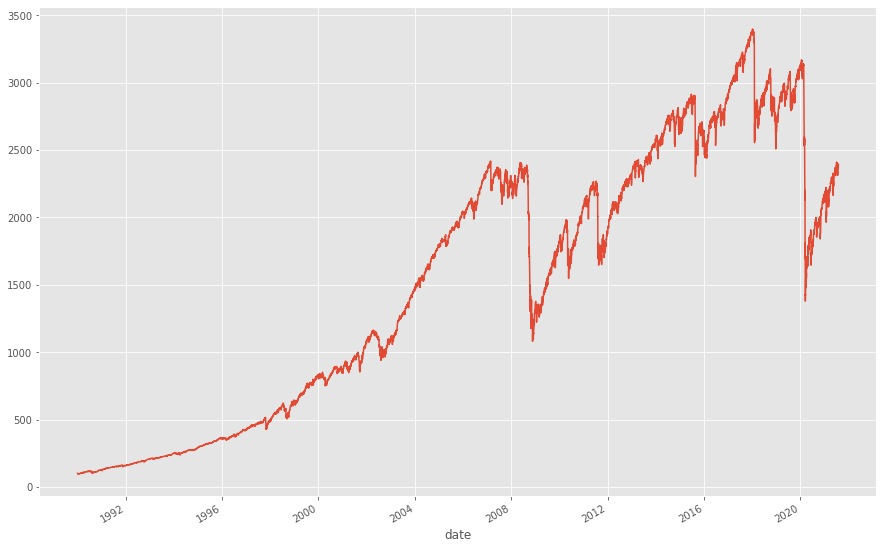

In [74]:
volswap_df['vrp_const_mat'].plot()

Text(0.5, 1.0, 'Short Volatility Strategies')

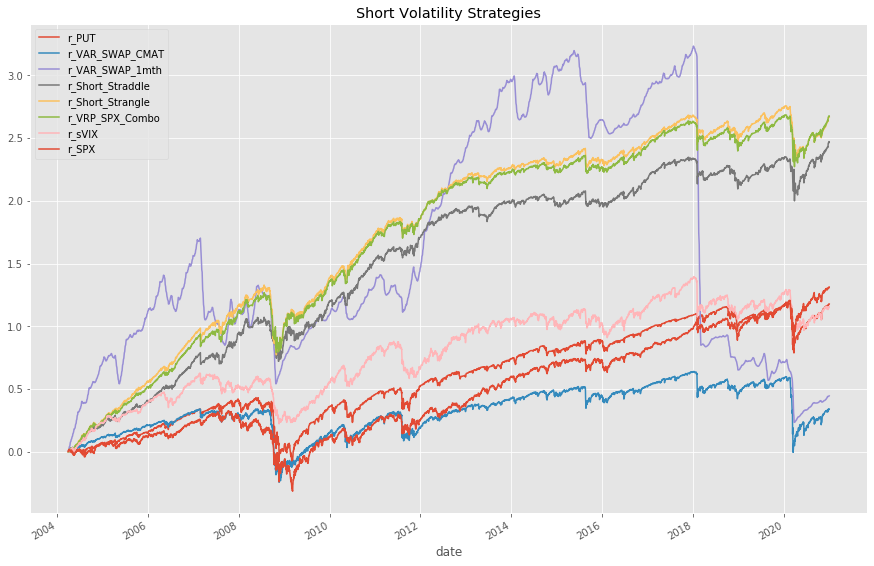

In [86]:

us_df['r_VAR_SWAP_1mth'] = volswap_df[['pnl_vol_tgt']].copy()
us_df['VAR_SWAP'] = volswap_df['vrp_const_mat'].copy()
us_df['r_VAR_SWAP_CMAT'] = us_df['VAR_SWAP'].pct_change()
us_df[['r_PUT','r_VAR_SWAP_CMAT', 'r_VAR_SWAP_1mth','r_Short_Straddle',
       'r_Short_Strangle','r_VRP_SPX_Combo','r_sVIX','r_SPX']].\
                dropna().apply(lambda x: x*(0.01/x.std())).apply(lambda x: 1+x).cumprod().apply(np.log).plot()
plt.title('Short Volatility Strategies')

In [89]:
us_df[['r_PUT','r_VAR_SWAP_CMAT', 'r_VAR_SWAP_1mth','r_Short_Straddle',
       'r_Short_Strangle','r_VRP_SPX_Combo','r_sVIX','r_SPX']].dropna().apply(get_port_stats)

,r_PUT,r_VAR_SWAP_CMAT,r_VAR_SWAP_1mth,r_Short_Straddle,r_Short_Strangle,r_VRP_SPX_Combo,r_sVIX,r_SPX
Compound Return,0.064806,0.021113,0.029511,0.040379,0.034575,0.036551,NaN,0.097064
Volatility,0.138564,0.213374,0.219320,0.040058,0.031819,0.033552,0.801108,0.194637
Max DD,0.370940,0.594221,0.985424,0.080437,0.100722,0.092216,1.184648,0.552502
Sharpe Ratio,0.435169,0.153542,0.196746,0.704853,0.702181,0.724449,0.500569,0.511142


In [88]:
us_df[['r_PUT','r_VAR_SWAP_CMAT', 'r_VAR_SWAP_1mth','r_Short_Straddle',
       'r_Short_Strangle','r_VRP_SPX_Combo','r_sVIX','r_SPX']].corr()

,r_PUT,r_VAR_SWAP_CMAT,r_VAR_SWAP_1mth,r_Short_Straddle,r_Short_Strangle,r_VRP_SPX_Combo,r_sVIX,r_SPX
r_PUT,1.000000,0.750032,0.097558,0.290728,0.358359,0.343561,0.650872,0.884969
r_VAR_SWAP_CMAT,0.750032,1.000000,0.179798,0.587091,0.686353,0.670389,0.810108,0.721172
r_VAR_SWAP_1mth,0.097558,0.179798,1.000000,0.144773,0.160881,0.160067,0.207501,0.088826
r_Short_Straddle,0.290728,0.587091,0.144773,1.000000,0.857524,0.946562,0.501091,0.232085
r_Short_Strangle,0.358359,0.686353,0.160881,0.857524,1.000000,0.977619,0.555658,0.300879
r_VRP_SPX_Combo,0.343561,0.670389,0.160067,0.946562,0.977619,1.000000,0.550734,0.283543
r_sVIX,0.650872,0.810108,0.207501,0.501091,0.555658,0.550734,1.000000,0.708141
r_SPX,0.884969,0.721172,0.088826,0.232085,0.300879,0.283543,0.708141,1.000000
